# Question 2b6
For RNN networks implemented in (3) and (4), perform the following experiments with the aim of improving performances, compare the accuracies and report your findings:

a. Replace the GRU layer with (i) a vanilla RNN layer and (ii) a LSTM layer

b. Increase the number of RNN layers to 2 layers

c. Add gradient clipping to RNN training with clipping threshold = 2.

# Imports and Setup

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# chuanxin
%cd "../gdrive/My Drive/cz4042_assignment_2/2b" 

Mounted at /gdrive
/gdrive/My Drive/cz4042_assignment_2/2b


In [3]:
import os
import time
import json
import csv
import re
import collections

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# Helper functions

### read_data_words()
Used to load in the data. Returns x_train, y_train, x_test, y_test

In [5]:
def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size

### clean_str(text)
Cleans a text and gets right of unwanted characters

In [6]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text

### build_word_dict(contents)
Self-explanatory

In [7]:
def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict

### preprocess(contents, word_dict, document_max_len)
Clean up a string 

In [8]:
def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x

### make_directories()
Used to create directories that might not have been made

In [9]:
# Create folder to store histories and figures
def make_directories():
  if not os.path.exists('./histories'):
    os.mkdir('./histories')
  if not os.path.exists('./figures'):
    os.mkdir('./figures')

### history_saver(history, filename, already_json=False)
Used to save a history object

In [10]:
# filename like 'history/model_name.json'
def history_saver(history, model_name, already_json=False):
  history_json = {}

  if already_json:
    history_json = history
  else:
    history = history.history
    for key in history.keys():
      history_json[key] = history[key]

  with open('./histories/' + model_name, 'w') as file:
    json.dump(history_json, file)

  print("History saved")

### history_loader(filename)
Used to load in a json history object

In [11]:
# filename like 'history/model_name.json'
def history_loader(model_name):
  with open('./histories/'+model_name) as json_file:
    history = json.load(json_file)
  print('History loaded')
  
  return history 

### plot_loss(history_json, model_name)
Plot out loss graph, and also save it

In [12]:
def plot_loss(history_json, model_name):
  train_loss = history_json['loss']
  test_loss = history_json['test_loss']
  title = 'Model name: ' + model_name + '\nloss against epochs'

  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_loss.png')
  
  plt.show()

### plot_acc(history_json, model_name)
Plot out accuracy graph, and also save it

In [13]:
def plot_acc(history_json, model_name):
  train_acc = history_json['accuracy']
  test_acc = history_json['test_accuracy']
  title = 'Model name: ' + model_name + '\naccuracy against epochs'

  plt.plot(train_acc, label='train')
  plt.plot(test_acc, label='test')
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_accuracy.png')
  
  plt.show()

# 2b6 - Comparison between models
1. GRU vs Vanilla vs LSTM
2. Number of GRU layers
3. Gradient clipping on GRU

In [21]:
def compare_test_acc(histories_json, filename, start_from_epoch=None, title=None):
  fig = plt.figure(figsize=(20,10))

  for model_name in histories_json.keys():  
    if start_from_epoch == None:
      test_acc = histories_json[model_name][model_name]['test_accuracy']
    else:
      test_acc = histories_json[model_name][model_name]['test_accuracy'][start_from_epoch:]
    plt.plot(test_acc, label=model_name + ", time taken: " + str(histories_json[model_name][model_name]['time_taken']))    
  
  if title == None:
    title = 'test accuracy against epochs'
    plt.title(title)
  else:
    plt.title(title)
  plt.ylabel('test accuracy')
  plt.xlabel('epochs')
  plt.legend(loc='center right')
  
  plt.savefig(f'./figures/{filename}.png')

  plt.show()

In [22]:
fnames_histories = next(os.walk('./histories'))[2]

histories_json = {}

for fname in fnames_histories:
  if fname[:2] in ['q6']:
    histories_json[fname] = history_loader(fname)

histories_json['q3_char_rnn_gru'] = history_loader('q3_char_rnn_gru')
histories_json['q4_word_rnn_gru'] = history_loader('q4_word_rnn_gru')

History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded
History loaded


In [23]:
histories_json.keys()

dict_keys(['q6_a_ii_1_char_rnn_lstm', 'q6_a_ii_2_word_rnn_lstm', 'q6_b_2_word_rnn_gru_two_layer', 'q6_b_1_char_rnn_gru_two_layer', 'q6_c_1_char_rnn_gru_gradient_clipping', 'q6_c_2_word_rnn_gru_gradient_clipping', 'q6_a_i_1_char_rnn_vanilla', 'q6_a_i_2_word_rnn_vanilla', 'q3_char_rnn_gru', 'q4_word_rnn_gru'])

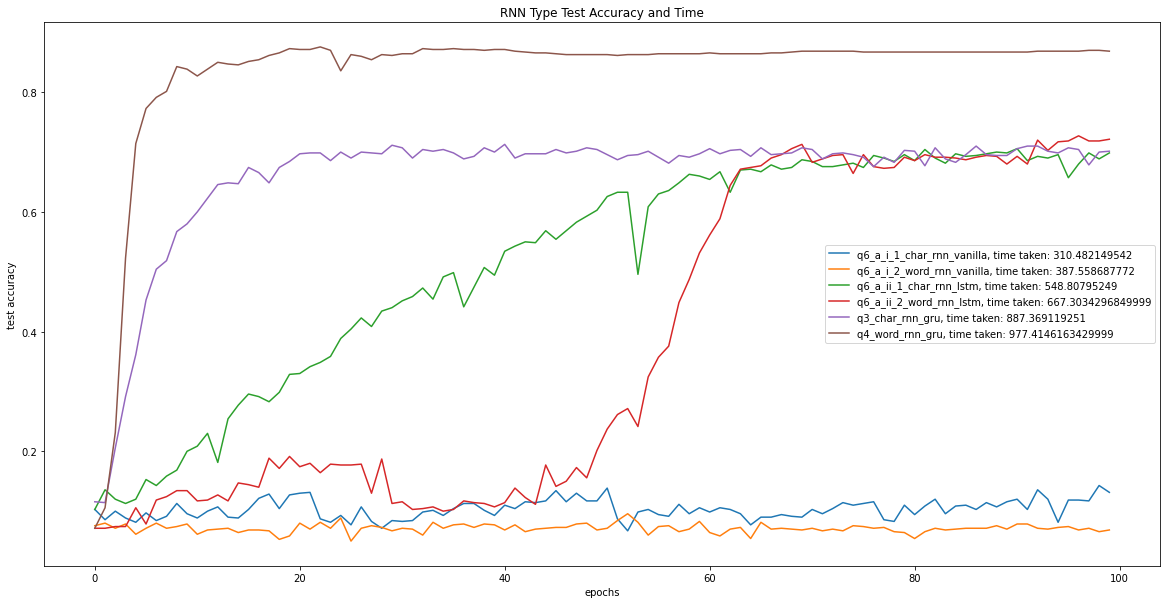

In [24]:
models_rnn_type = {}
models_rnn_type_filename = 'q6_compare_rnn_type'
models_rnn_type_title = 'RNN Type Test Accuracy and Time'

for model_name in ['q6_a_i_1_char_rnn_vanilla', 'q6_a_i_2_word_rnn_vanilla', 'q6_a_ii_1_char_rnn_lstm', 'q6_a_ii_2_word_rnn_lstm', 'q3_char_rnn_gru', 'q4_word_rnn_gru']:
  models_rnn_type[model_name] = histories_json[model_name]

compare_test_acc(models_rnn_type, models_rnn_type_filename, start_from_epoch=None, title=models_rnn_type_title)

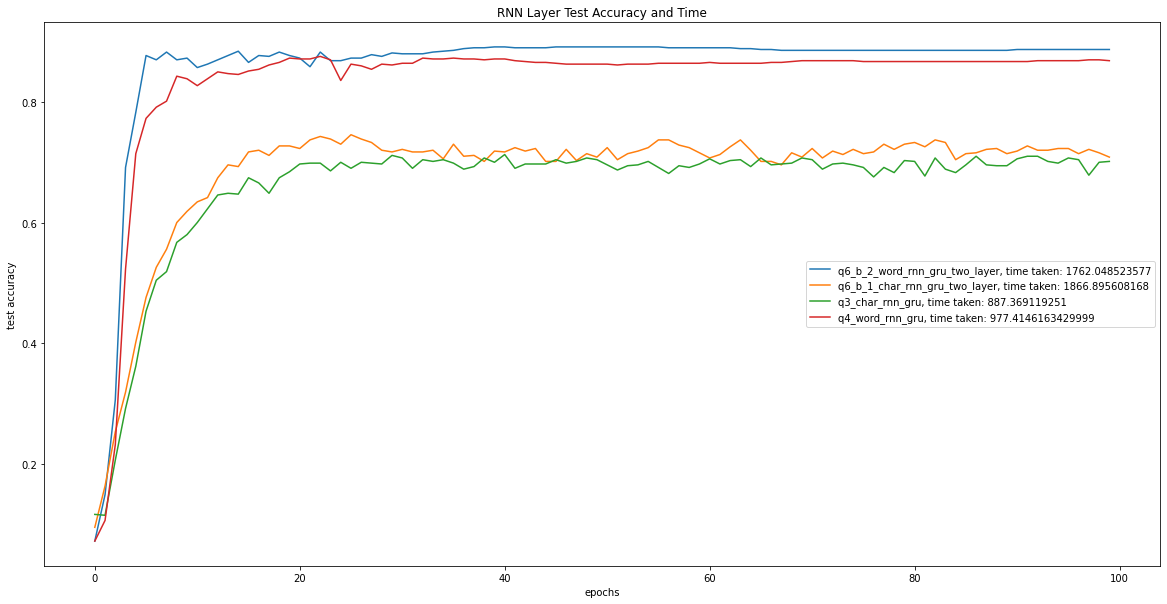

In [25]:
models_rnn_gru_layer = {}
models_rnn_gru_layer_filename = 'q6_compare_rnn_layer'
models_rnn_gru_layer_title = 'RNN Layer Test Accuracy and Time'

for model_name in ['q6_b_2_word_rnn_gru_two_layer', 'q6_b_1_char_rnn_gru_two_layer', 'q3_char_rnn_gru', 'q4_word_rnn_gru']:
  models_rnn_gru_layer[model_name] = histories_json[model_name]

compare_test_acc(models_rnn_gru_layer, models_rnn_gru_layer_filename, start_from_epoch=None, title=models_rnn_gru_layer_title)

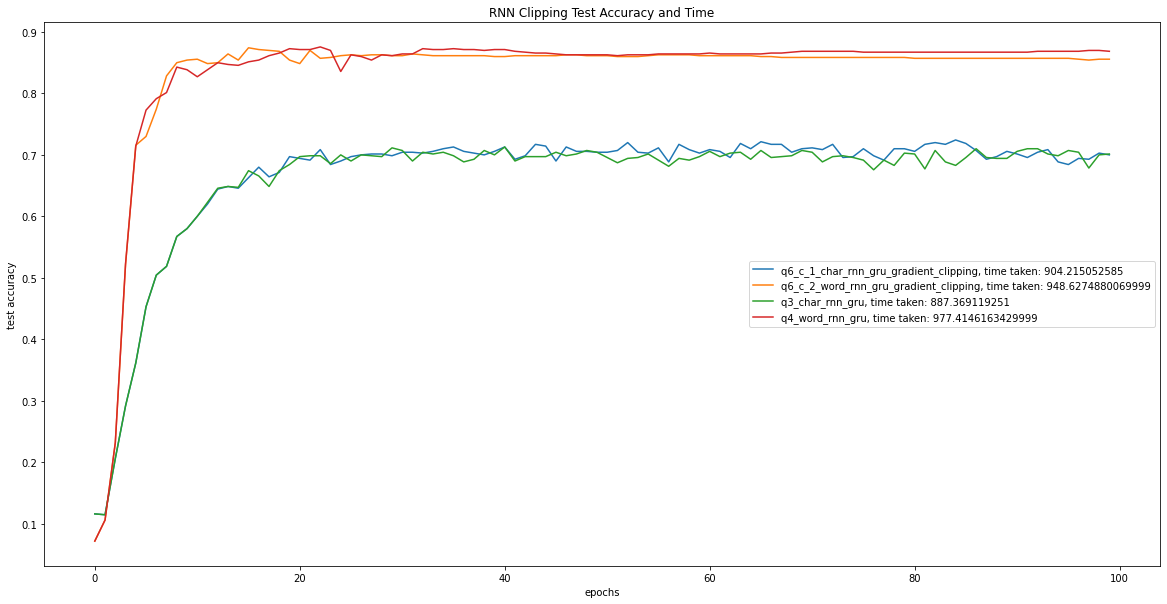

In [26]:
models_rnn_gru_clipping = {}
models_rnn_gru_clipping_filename = 'q6_compare_rnn_clipping'
models_rnn_gru_clipping_title = 'RNN Clipping Test Accuracy and Time'

for model_name in ['q6_c_1_char_rnn_gru_gradient_clipping', 'q6_c_2_word_rnn_gru_gradient_clipping', 'q3_char_rnn_gru', 'q4_word_rnn_gru']:
  models_rnn_gru_clipping[model_name] = histories_json[model_name]

compare_test_acc(models_rnn_gru_clipping, models_rnn_gru_clipping_filename, start_from_epoch=None, title=models_rnn_gru_clipping_title)